In [4]:
import os

import fiona
import rasterio
import numpy as np
import pandas as pd
import geopandas as gpd
import rasterio.mask
import shapely.speedups
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

from scipy import stats
from rasterio.plot import show
from rasterio.features import shapes
from shapely.geometry import shape
from joblib import delayed, Parallel
from scipy.ndimage import gaussian_filter1d
from matplotlib.ticker import ScalarFormatter, FormatStrFormatter, FixedLocator


# enable shapely speedups for topology operations
shapely.speedups.enable()

import seaborn as sns; sns.set()


In [5]:
data_dir = '/Users/d3y010/projects/atiim/data'

gage_data_file = os.path.join(data_dir, 'tabular', 'water_level.csv')
dem_file = os.path.join(data_dir, 'raster', 'run_1_all.sdat')
basin_shp = os.path.join(data_dir, 'shp', 'basin_1.shp')
gage_shp = os.path.join(data_dir, 'shp', 'gage_location_1.shp')

output_dir = '/Users/d3y010/projects/atiim/test'

run_name = 'test_1'
elevation_interval = 0.1
hour_interval = 1.0


In [6]:
def calculate_inflection(df):

    # smooth data using a Gausian filter
    # smoothed_area = gaussian_filter1d(fdf.area, 100)

    # calucate the second derivative
    second_deriv = np.gradient(np.gradient(df.area))

    # get the index locations in the second derivative plot representing the sign change (a.k.a., inflection points) 
    inflection_indices = np.where(np.diff(np.sign(second_deriv)))[0]

    # drop the first value in the series if it shows up as an inflection point
    inflection_indices = inflection_indices[inflection_indices > 0]

    # bankfull elevation is determined by the first inflection point
    bankfull_elevation = df['elevation'].values[inflection_indices[0]]
    
    bankfull_area = df['area'].values[inflection_indices[0]]
    
    return bankfull_elevation, bankfull_area


def process_gage_data(gage_data_file):

    df = pd.read_csv(gage_data_file)
    
    print(f"Total Time Steps:  {df.shape[0]}")

    # convert date and time strings to a pandas datetime type
    df['date_time'] = pd.to_datetime(df['DATE'] + ' ' + df['TIME'], infer_datetime_format=True)
    
    # calculate the number of days in the file
    n_days = (df['date_time'].max() - df['date_time'].min()).days

    print(f"Days Verification:  {n_days}")
    
    # sort df by date_time
    df.sort_values(by=['date_time'], inplace=True)

    min_wtr_elev = df['WL_ELEV_M'].min()
    max_wtr_elev = df['WL_ELEV_M'].max()
    wtr_elev_list = df['WL_ELEV_M'].tolist()
    day_part, hour_interval = 1, 1
    d_freq = df['WL_ELEV_M'].value_counts().to_dict()
    
    return min_wtr_elev, max_wtr_elev, d_freq



def create_basin_dem(basin_shp, dem_file, output_directory, run_name):
    """Mask the input DEM using a basin geometry representative of the contributing area.
    
    
    """

    # dissolve target basin geometries
    basin_geom = gpd.read_file(basin_shp).dissolve().geometry.values[0]
    
    with rasterio.open(dem_file) as src:
        
        if src.crs is None:
            print("Warning:  Input DEM raster does not have a defined coordinate reference system.")
        
        # apply basin geometry as a mask
        out_image, out_transform = rasterio.mask.mask(src, basin_geom, crop=True)
        
        # update the raster metadata with newly cropped extent
        out_meta = src.meta
        out_meta.update({"driver": "GTiff",
                         "height": out_image.shape[1],
                         "width": out_image.shape[2],
                         "transform": out_transform})

        # write outputs
        output_file = os.path.join(output_directory, f"dem_masked_{run_name}.tif")
        with rasterio.open(output_file, "w", **out_meta) as dest:
            dest.write(out_image)
            
        return output_file


def process_slice(arr, upper_elev, output_directory, gage_gdf, water_elev_freq, run_name, hour_interval, transform, target_crs):
    """Create a water level polygon shapefile containing a single feature that represents
    the grid cells of an input DEM that are less than or equal to an upper elevation level.
    
    """
    # TODO:  fix target_crs reference from raster
    
    # generate a feature id from the elevation value
    feature_id = int(upper_elev * 100)

    # create every value greater than or equal to the upper elevation to 1, others to 0
    arx = np.where(arr <= upper_elev, 1, 0).astype(np.int16)

    # build each feature based on the extracted grid cells from the array
    results = list(
        {'properties': {'raster_val': val}, 'geometry': shp}
        for index, (shp, val)  in enumerate(
            shapes(arx, mask=None, transform=transform))
    )

    # list of geometries
    geoms = list(results)

    # build geopandas dataframe from geometries
    gdf = gpd.GeoDataFrame.from_features(geoms, crs=gage_gdf.crs)

    # only keep the ones
    gdf = gdf.loc[gdf['raster_val'] == 1]
    
    # only keep the polygon intersecting the gage
    gdf['valid'] = gdf.intersects(gage_gdf.geometry.values[0])
    gdf = gdf.loc[gdf['valid']].copy()
    
    # ensure at least one polygon intersects the gage
    if gdf.shape[0] == 0:
        msg = "Gage location point not aligned with valid elevation in DEM.  Relocate gage location point to fall within valid elevation."
        raise AssertionError(msg)

    # dissolve into a single polygon
    gdf = gdf.dissolve('raster_val')
    gdf.reset_index(inplace=True)
    
    # add fields 
    gdf['id'] = feature_id
    gdf['frequency'] = water_elev_freq[round(upper_elev, 1)]
    gdf['elevation'] = upper_elev
    gdf['area'] = gdf.geometry.area
    gdf['hectares'] = gdf['area'] * 0.0001
    gdf['perimeter'] = gdf.geometry.length
    gdf['hectare_hours'] = (gdf['frequency'] / hour_interval) * gdf['hectares']
    
    # drop unneeded fields
    gdf.drop(columns=['raster_val', 'valid'], inplace=True)

    # write to file
    out_file = os.path.join(output_directory, f'wl_{feature_id}_{run_name}.shp')
    gdf.to_file(out_file)
    
    return gdf


def simulate_inundation(dem_file, 
                            basin_shp,
                            gage_shp,
                            gage_data_file, 
                            output_directory, 
                            run_name, 
                            elevation_interval=0.1,
                            hour_interval=1.0):

    # process gage data file
    min_gage_elev, max_gage_elev, water_elev_freq = process_gage_data(gage_data_file)
    
    # read in gage shapefile to a geodataframe
    gage_gdf = gpd.read_file(gage_shp)
    
    with rasterio.Env():
        
        # clip the input DEM to a target basin contributing area
        masked_dem_file = create_basin_dem(basin_shp, dem_file, output_directory, run_name)

        with rasterio.open(masked_dem_file) as src:

            # read the raster band into a number array
            arr = src.read(1)

            # convert the raster nodata value to numpy nan
            arr[arr == src.nodata] = np.nan

            raster_min = np.nanmin(arr)
            raster_max = np.nanmax(arr)
          
            # use the minimum bounding elevation e.g., the max of min available
            elev_min = max([min_gage_elev, raster_min])
            
            # use the maximum bounding elevation e.g., the min of max available
            elev_max = min([max_gage_elev, raster_max])
            
            # construct elevation upper bounds to process for each slice
            elev_slices = np.arange(elev_min, elev_max + elevation_interval, elevation_interval)
                       
            print(f"Minimum DEM Elevation:  {round(raster_min, 2)}")
            print(f"Maximum DEM Elevation:  {round(raster_max, 2)}")
            print(f"Minimum Water-Surface Elevation:  {round(min_gage_elev, 2)}")
            print(f"Maximum Water-Surface Elevation:  {round(max_gage_elev, 2)}")
            print(f"Bounded DEM Elevation:  {round(min(elev_slices), 2)}")
            print(f"Bounded DEM Elevation:  {round(max(elev_slices), 2)}")
            
#             feature_list = []
#             for upper_elev in elev_slices:
#                 print(f"Processing:  {upper_elev}")
#                 s = process_slice(arr, upper_elev, output_directory, gage_gdf, run_name, src.transform, src.crs)
#                 feature_list.append(s)

            # process all elevation slices in parallel
            feature_list = Parallel(n_jobs=-1)(
                delayed(process_slice)(arr, 
                                       upper_elev, 
                                       output_directory, 
                                       gage_gdf, 
                                       water_elev_freq, 
                                       run_name, 
                                       hour_interval, 
                                       src.transform, 
                                       src.crs) 
                for upper_elev in elev_slices)
        
            return feature_list


In [7]:
%%time

feature_list = simulate_inundation(dem_file, 
                                        basin_shp,
                                        gage_shp,
                                        gage_data_file, 
                                        output_dir, 
                                        run_name, 
                                        elevation_interval=elevation_interval,
                                        hour_interval=hour_interval)

fdf = pd.concat(feature_list)

fdf.head()


Total Time Steps:  3568
Days Verification:  148
Minimum DEM Elevation:  0.6800000071525574
Maximum DEM Elevation:  19.889999389648438
Minimum Water-Surface Elevation:  1.0
Maximum Water-Surface Elevation:  3.6
Bounded DEM Elevation:  1.0
Bounded DEM Elevation:  3.6


/Users/d3y010/.pyenv/versions/3.9.4/envs/py3.9.4_atiim/lib/python3.9/site-packages/rasterio/features.py:441: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  all_bounds = [bounds(shape, transform=~dataset.transform) for shape in shapes]
/Users/d3y010/.pyenv/versions/3.9.4/envs/py3.9.4_atiim/lib/python3.9/site-packages/rasterio/features.py:284: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for index, item in enumerate(shapes):
/var/folders/1q/kbqf0s_90m907n320mhb_gq46y9fxr/T/ipykernel_18003/50875027.py:138: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
/var/folders/1q/kbqf0s_90m907n320mhb_gq46y9fxr/T/ipykernel_18003/50875027.py:138: Use

CPU times: user 593 ms, sys: 119 ms, total: 712 ms
Wall time: 2.3 s


,geometry,id,frequency,elevation,area,hectares,perimeter,hectare_hours
0,"POLYGON ((446947.500 5128512.631, 446952.000 5...",100,2,1.0,1785.3750,0.178538,631.5,0.357075
0,"POLYGON ((446949.000 5128514.131, 446956.500 5...",110,523,1.1,2291.0625,0.229106,642.0,119.822569
0,"POLYGON ((446955.750 5128516.381, 446958.750 5...",120,462,1.2,2656.6875,0.265669,657.0,122.738962
0,"POLYGON ((447280.500 5128854.631, 447282.750 5...",130,231,1.3,5967.0000,0.596700,2023.5,137.837700
0,"POLYGON ((447281.250 5128857.631, 447283.500 5...",140,177,1.4,7023.3750,0.702338,2086.5,124.313738


In [8]:
df = pd.read_csv(gage_data_file)

# convert date and time strings to a pandas datetime type
df['date_time'] = pd.to_datetime(df['DATE'] + ' ' + df['TIME'], infer_datetime_format=True)

df.head(2)


,RECORD,DATE,TIME,TEMP_C,WL_ELEV_M,date_time
0,8916,2/1/2008,5:15:21 PM,3.893,2.9,2008-02-01 17:15:21
1,8918,2/1/2008,6:15:21 PM,3.893,2.7,2008-02-01 18:15:21


In [12]:
df['WL_ELEV_M'].shape


(3568,)

In [13]:
type(x)

NameError: name 'x' is not defined

In [ ]:
sns.set(style='whitegrid', font_scale=1.2) 

fig, ax = plt.subplots(figsize=(12, 8))

# g = sns.lineplot(x="date_time", 
#                   y="WL_ELEV_M",
#                   data=df,
#                   color='blue',
#                   alpha=0.7)

# x = ax.set(ylabel='Water Surface Elevation (m)',
#            xlabel=None,
#            title='Water Surface Elevation Gage Measurements')

# plt.xlim(xmin=df['date_time'].min(), xmax=df['date_time'].max())

# gx = plt.xticks(rotation = 45)

# create x-axis steps for water elevation
x_data = np.linspace(df[elevation_field_name].min(),
                     df[elevation_field_name].max() * x_padding,
                     num=n_samples)

ax.hist(df['WL_ELEV_M'].sort_values(), bins=21, normed=True, label='data')
ax.plot()


### Water Surface Elevation Gage Measurements

In [17]:
df = pd.read_csv(gage_data_file)

# convert date and time strings to a pandas datetime type
df['date_time'] = pd.to_datetime(df['DATE'] + ' ' + df['TIME'], infer_datetime_format=True)

sns.set(style='whitegrid', font_scale=1.2) 

fig, ax = plt.subplots(figsize=(12, 8))

g = sns.lineplot(x="date_time", 
                  y="WL_ELEV_M",
                  data=df,
                  color='blue',
                  alpha=0.7)

x = ax.set(ylabel='Water Surface Elevation (m)',
           xlabel=None,
           title='Water Surface Elevation Gage Measurements')

plt.xlim(xmin=df['date_time'].min(), xmax=df['date_time'].max())

gx = plt.xticks(rotation = 45)

plt.savefig('/Users/d3y010/Desktop/test.png')
plt.close()


### Hectare hours of inundation

In [12]:
fdf['hectare_hours'].max() * .05

92.13073875

In [18]:
255 * 0.15

38.25

Text(0, 0.5, 'Water Surface Elevation (m)')

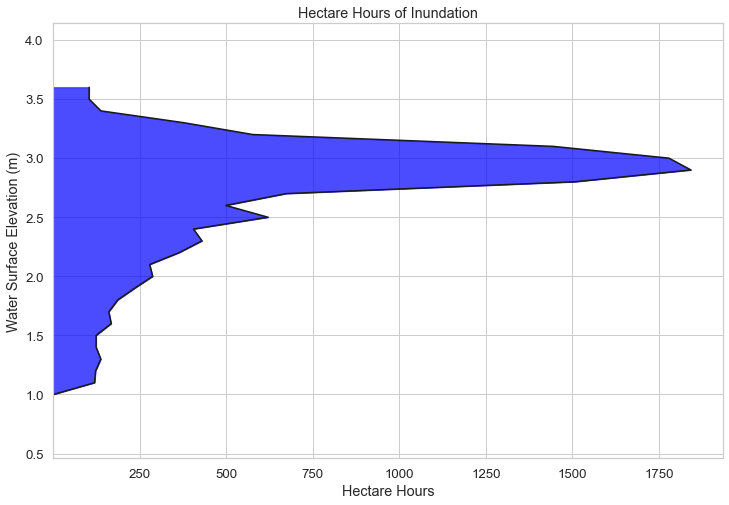

In [14]:
sns.set(style='whitegrid', font_scale=1.2) 

fig, ax = plt.subplots(figsize=(12, 8))

# pad min and max Y values for axis
y_padding = fdf['elevation'].max() * 0.15

# pad max x axis value
x_padding = fdf['hectare_hours'].max() * .05

plt.ylim(ymin=(fdf['elevation'].min() - y_padding), ymax=(fdf['elevation'].max() + y_padding))
plt.xlim(xmin=fdf['hectare_hours'].min(), 
         xmax=fdf['hectare_hours'].max() + x_padding)

plt.plot(fdf['hectare_hours'], fdf['elevation'], 'k')

plt.fill_betweenx(fdf['elevation'], fdf['hectare_hours'], color='blue', alpha=0.7)

plt.title('Hectare Hours of Inundation')
plt.xlabel('Hectare Hours')
plt.ylabel('Water Surface Elevation (m)')



In [7]:
fdf.head()

,geometry,id,frequency,elevation,area,hectares,perimeter,hectare_hours
0,"POLYGON ((446947.500 5128512.631, 446947.500 5...",100,2,1.0,1785.3750,0.178538,631.5,0.357075
0,"POLYGON ((446949.000 5128514.131, 446949.000 5...",110,523,1.1,2291.0625,0.229106,642.0,119.822569
0,"POLYGON ((446955.750 5128516.381, 446955.750 5...",120,462,1.2,2656.6875,0.265669,657.0,122.738962
0,"POLYGON ((447280.500 5128854.631, 447280.500 5...",130,231,1.3,5967.0000,0.596700,2023.5,137.837700
0,"POLYGON ((447281.250 5128857.631, 447281.250 5...",140,177,1.4,7023.3750,0.702338,2086.5,124.313738


In [12]:
100 * 1.1


110.00000000000001

### CDF

3.6
3.7800000000000002


(1.0, 3.6)

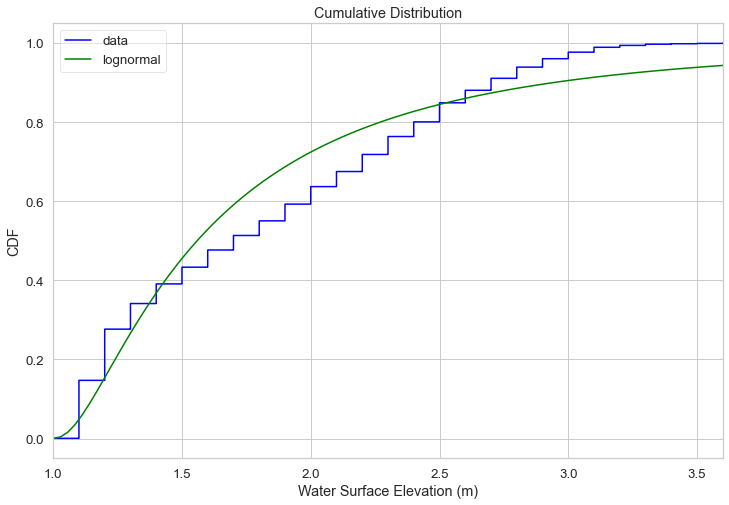

In [81]:
sns.set(style='whitegrid', font_scale=1.2) 

df = pd.read_csv(gage_data_file)

fig, ax = plt.subplots(figsize=(12, 8))

z_sort = df['WL_ELEV_M'].sort_values()

x_data = np.linspace(df['WL_ELEV_M'].min(), df['WL_ELEV_M'].max() * 1.05, 100)

s, loc, scale = stats.lognorm.fit(z_sort.values)

cum_dist = np.linspace(0., 1., z_sort.shape[0])

z_cdf = pd.Series(cum_dist, index=z_sort)

ep = 1. - z_cdf

z_cdf.plot(ax=ax, drawstyle='steps', label='data', color='blue')

ax.plot(x_data, stats.lognorm.cdf(x_data, s, loc, scale), label='lognormal', color='green')

ax.set_xlabel('Water Surface Elevation (m)')
ax.set_ylabel('CDF')

ax.legend(loc=0, framealpha=0.5) #, fontsize=14)
plt.title('Cumulative Distribution')

plt.xlim(xmin=x_data.min(), xmax=df['WL_ELEV_M'].max())


### Exceedence probability

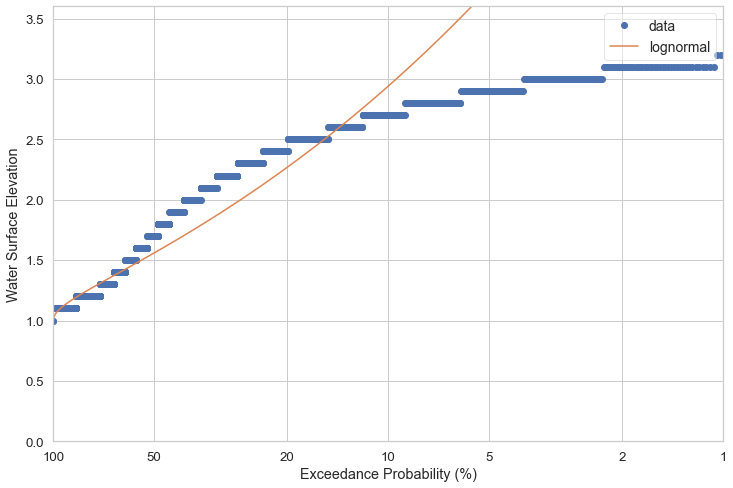

In [12]:
sns.set(style='whitegrid', font_scale=1.2) 

fig, ax = plt.subplots(figsize=(12, 8))

z_sort = df['WL_ELEV_M'].sort_values()

x_data = np.linspace(df['WL_ELEV_M'].min(), z_sort.max() * 1.1, 100)

s, loc, scale = stats.lognorm.fit(z_sort.values)

cum_dist = np.linspace(0., 1., z_sort.shape[0])

z_cdf = pd.Series(cum_dist, index=z_sort)

ep = 1. - z_cdf

ax.semilogx(100. * ep, z_sort.values, ls='', marker='o', label='data')
ax.plot(100. * (1. - stats.lognorm.cdf(x_data, s, loc, scale)), x_data, label='lognormal')

minor_locator = FixedLocator([1, 2, 5, 10, 20, 50, 100])

ax.xaxis.set_major_locator(minor_locator)
ax.xaxis.set_major_formatter(ScalarFormatter())
ax.xaxis.set_major_formatter(FormatStrFormatter("%d"))

ax.set_xlim(1, 100)
ax.set_ylim(0, df['WL_ELEV_M'].max())

ax.set_xlabel('Exceedance Probability (%)')
ax.set_ylabel('Water Surface Elevation')
ax.invert_xaxis()

ax.legend(loc=0, framealpha=0.5, fontsize=14)


### Inundation perimiter by water surface elevation

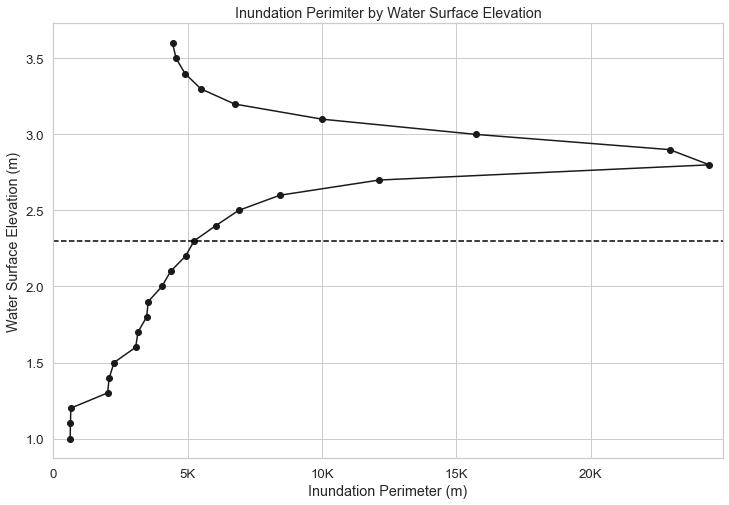

In [9]:

sns.set(style='whitegrid', font_scale=1.2) 


fig, ax = plt.subplots(figsize=(12, 8))

plt.plot(fdf.perimeter, fdf.elevation, 'ko', fdf.perimeter, fdf.elevation, 'k')

x = ax.set(ylabel='Water Surface Elevation (m)',
           xlabel='Inundation Perimeter (m)',
           title='Inundation Perimiter by Water Surface Elevation')

plt.axhline(fdf.elevation.mean(), color='black', linestyle="--", label='_nolegend_')

plt.xlim(xmin=0, xmax=fdf.perimeter.max() + 500)

ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:}'.format(int(x/1000)) + 'K' if x > 0 else int(x)))


### Inundation area by water surface elevation

1.2000000000000002 2656.6875


ValueError: cannot reindex from a duplicate axis

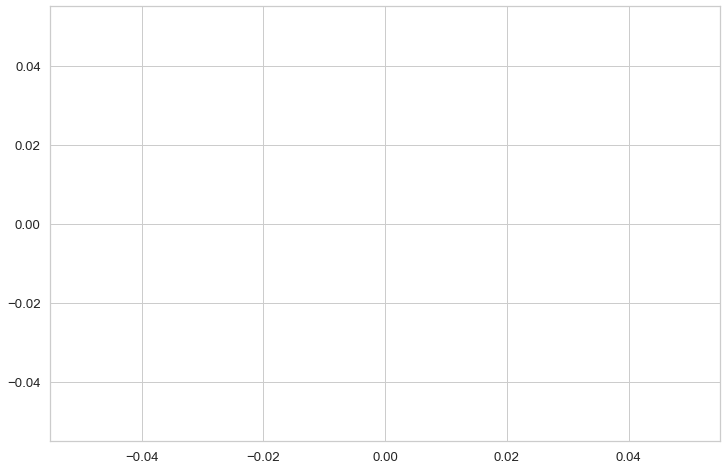

In [10]:
# calculate the inflection point for bankfull elevation
bankfull_elevation, bankfull_area = calculate_inflection(fdf)

print(bankfull_elevation, bankfull_area)

sns.set(style='whitegrid', font_scale=1.2) 


fig, ax = plt.subplots(figsize=(12, 8))

g = sns.lineplot(x="area", 
                  y="elevation",
                  marker='o',
                  data=fdf,
                  color='black')

x = ax.set(ylabel='Water Surface Elevation (m)',
           xlabel='Area (m$^2$)',
           title='Inundation Area by Water Surface Elevation')

plt.plot(bankfull_area, bankfull_elevation, 'r^', ms=14)


ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:}'.format(int(x/1000)) + 'K'))




In [133]:
def calculate_inflection(df):

    # smooth data using a Gausian filter
    # smoothed_area = gaussian_filter1d(fdf.area, 100)

    # calucate the second derivative
    second_deriv = np.gradient(np.gradient(df.area))

    # get the index locations in the second derivative plot representing the sign change (a.k.a., inflection points) 
    inflection_indices = np.where(np.diff(np.sign(second_deriv)))[0]

    # drop the first value in the series if it shows up as an inflection point
    inflection_indices = inflection_indices[inflection_indices > 0]

    # bankfull elevation is determined by the first inflection point
    bankfull_elevation = df['elevation'].values[inflection_indices[0]]
    
    return bankfull_elevation


[ 2  4  5  7 18]
1.2000000000000002


<AxesSubplot:xlabel='idx', ylabel='second_deriv_scaled'>

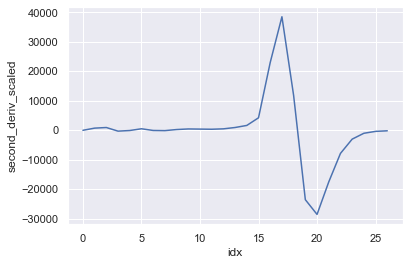

In [125]:
sns.lineplot(x="idx", 
             y="second_deriv_scaled",
             #hue="region", 
             #style="event",
             data=fdf)


In [126]:
fdf.elevation.values[inflects]

array([1. , 1.2, 1.4, 1.5, 1.7, 2.8])

In [110]:
fdf.head()

,geometry,id,frequency,elevation,area,hectares,perimeter,hectare_hours,second_deriv,second_deriv_scaled,idx
0,"POLYGON ((446947.500 5128512.631, 446947.500 5...",100,2,1.0,1785.3750,0.178538,631.5,0.357075,-70.031250,-70.031250,0
0,"POLYGON ((446949.000 5128514.131, 446949.000 5...",110,523,1.1,2291.0625,0.229106,642.0,119.822569,666.140625,666.140625,1
0,"POLYGON ((446955.750 5128516.381, 446955.750 5...",120,462,1.2,2656.6875,0.265669,657.0,122.738962,873.843750,873.843750,2
0,"POLYGON ((447280.500 5128854.631, 447280.500 5...",130,231,1.3,5967.0000,0.596700,2023.5,137.837700,-353.531250,-353.531250,3
0,"POLYGON ((447281.250 5128857.631, 447281.250 5...",140,177,1.4,7023.3750,0.702338,2086.5,124.313738,-140.343750,-140.343750,4


In [246]:
masked_dem_file = os.path.join(output_dir, 'dem_masked_test_1.tif')

def hypsometric_curve(dem_file, elevation_interval, min_elevation=None, max_elevation=None, 
                      plot_area=False, plot_percent=False, save_plot=False):
    """Calculate a hypsometric curve as an elevation-area relationship Assessment metric 
    of the landform shape at a site.  Provides basic metric of opportunity for inundation and 
    habitat opportunity.
    
    """

    # create a dictionary to hold results
    result_dict = {'dem_elevation': [], 'dem_area_at_elevation': []}

    with rasterio.open(dem_file) as src:

        # read the raster band into a number array
        arr = src.read(1)

        # convert the raster nodata value to numpy nan
        arr[arr == src.nodata] = np.nan
        
        # grid cell resolution
        grid_cell_area = np.abs(src.transform[0] * src.transform[4])
        
        # set minimum and maximum elevation value; use raster determined values by default
        if min_elevation is None:
            min_elevation = np.nanmin(arr)
        
        if max_elevation is None:
            max_elevation = np.nanmax(arr)

        # create elevation intervals to process
        elev_slices = np.arange(min_elevation, max_elevation + elevation_interval, elevation_interval)

        # calculate each area at elevation intervals
        for i in elev_slices:
            result_dict['dem_elevation'].append(i)
            result_dict['dem_area_at_elevation'].append(np.where(arr >= i)[0].shape[0] * grid_cell_area)

        # convert results to data frame
        df = pd.DataFrame(result_dict)

        # calculate the total area
        total_area = df['dem_area_at_elevation'].max()

        # calculate percent area per elevation slice
        df['dem_percent_area'] = df['dem_area_at_elevation'] / total_area
        
        if plot_area:
            ax = sns.lineplot(x="dem_area_at_elevation", 
                              y="dem_elevation",
                              marker='o',
                              data=df)
        if plot_percent:
            ax = sns.lineplot(x="dem_percent_area", 
                              y="dem_elevation",
                              marker='o',
                              data=df)

        return df
    
df = hypsometric_curve(masked_dem_file, elevation_interval, plot_area=False)



How much area exist at the max elevation?

At 19 m there is this much area available.


In [204]:
df['dem_area_at_elevation'].sum()

66011627.8125

In [207]:
df

,dem_elevation,dem_area_at_elevation,dem_percent_area
0,0.682365,1.1250,1.704245e-08
1,0.782365,309.3750,4.686674e-06
2,0.882365,892.6875,1.352319e-05
3,0.982365,1859.6250,2.817117e-05
4,1.082365,3094.8750,4.688379e-05
...,...,...,...
189,19.582365,515429.4375,7.808161e-03
190,19.682365,516335.6250,7.821889e-03
191,19.782365,516816.0000,7.829166e-03
192,19.882365,516906.5625,7.830538e-03


In [247]:
df.head()

,dem_elevation,dem_area_at_elevation,dem_percent_area
0,0.682365,516908.2500,1.000000
1,0.782365,516598.8750,0.999401
2,0.882365,516015.5625,0.998273
3,0.982365,515048.6250,0.996402
4,1.082365,513813.3750,0.994013


NameError: name 'df' is not defined

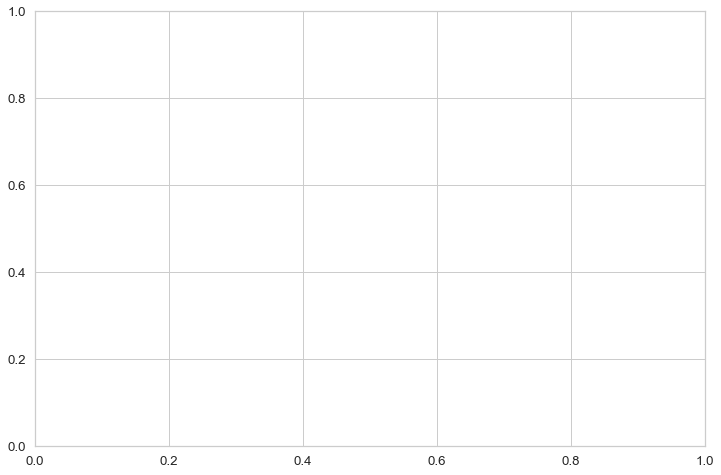

In [7]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

sns.set(style='whitegrid', font_scale=1.2) 


fig, ax = plt.subplots(figsize=(12, 8))

g = sns.lineplot(x="dem_area_at_elevation", 
                  y="dem_elevation",
                  marker='o',
                  data=df,
                  color='black')

x = ax.set(ylabel='Elevation (m)',
           xlabel='Area (m$^2$)',
           title='Hypsometric')

ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:}'.format(int(x/1000)) + 'K'))



In [287]:
'{:}'.format(12.34)

'12.34'